In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
from joblib import Parallel, delayed
import importlib
#importlib.reload(CALCULATE)

Welcome to JupyROOT 6.26/06


In [69]:
muN=1.9103 #minus

In [2]:
import sys
import re

class Filter:
    def __init__(self):
        self.old_stderr = sys.stderr
        sys.stderr = self

    def write(self, message):
        # Change the pattern here to match the specific ROOT errors
        if not re.search(r"Error in <TList::Clear>:", message):
            self.old_stderr.write(message)

    def flush(self):
        pass

# Apply the filter
filter = Filter()



Error in <THashList::Delete>: A list is accessing an object (0xca057f0) already deleted (list name = THashList)


In [3]:
pas="1"
config="3"

# Cuts

In [4]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: 0
W2max: 1.25
dxmin: -0.7
dxmax: 0.702
dymin: -0.9895
dymax: 0.9895
dybgmin: -1.2
dybgmax: 1.2
Q2: 6.83
Coin Min: 82 Coin Max: 106


In [5]:
cut="w2"
value=[W2min,W2max]
NUMBER=40

In [6]:
#w2
cutw2="w2"
valuemaxw2=np.linspace(.2,2.2,NUMBER)
valueminw2=np.linspace(0,0,NUMBER)

valuew2=np.transpose(np.stack([valueminw2,valuemaxw2],axis=0))

#dy
cutdy="dy"
valuemaxdy=np.linspace(.2,1.5,NUMBER)
valuemindy=np.linspace(-.2,-1.5,NUMBER)
valuedy=np.transpose(np.stack([valuemindy,valuemaxdy],axis=0))

#dx
cutdx="dx"
valuemaxdx=np.linspace(0.01,1,NUMBER)
valuemindx=np.linspace(-.01,-1,NUMBER)
valuedx=np.transpose(np.stack([valuemindx,valuemaxdx],axis=0))


# Calculate Raw Asymmetry, Fit dx and determine fA for bg,proton,accidentals- Calc Aphys

In [7]:
def Function_APHYSSENS(config,cut,value):
    import ROOT as r
    import math
    import array
    import os
    import sys
    import matplotlib.pyplot as plt
    import numpy as np

    #______________Add include directory_______________
    current_dir = os.getcwd()
    include_dir = os.path.join(current_dir, '../include')
    sys.path.insert(0, include_dir)
    #__________________________________________________
    import ERROR
    import CONFIG
    import DBPARSE
    import ASYMMETRY 
    import UTILITIES 
    from SIMFITS import DistributionFits
    from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
    import CALCULATE
    import CORRECTIONS
    from joblib import Parallel, delayed
    
    dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
    dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
    lower_bound=dxmin
    upper_bound=dxmax
    Raw=ASYMMETRY.Function_ASYMMETRYSENS(config,cut,value)
    print("Raw Asymmetry Calculated")
    
    Fit=ASYMMETRY.Function_FITDXSENS(config,cut,value)
    print("dx Histogram Fit Completed")
    
    data,bg,totalFit,simp,simn=Fit
    bin_centers,bin_contents=bg
    numBG=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    bin_centers,bin_contents=data
    numTotal=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    bin_centers,bin_contents=simp
    numP=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    
    accResult,bgResult,fp=CORRECTIONS.Function_ANALYZEROOTFILE(config,bg,simp,totalFit)
    
    bin_centers,bin_contents=simn
    Y=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    TrueYield=Raw[3]
    print("f A combinations Determined")
    
    Phys=ASYMMETRY.Function_APHYS(config,pas,Raw,accResult,bgResult,fp)
    print("Aphys Calculated")
    
    weighted_A,weighted_A_E,fbackg=Phys
    print('Returned: Aphys, Aphys_E, fbg, cut, cutvalue')
    R,RE=CALCULATE.Function_CALCGEN(config,weighted_A,weighted_A_E)
    return weighted_A,weighted_A_E,fbackg,cut,value,Y,R,RE

In [8]:
#Results=Function_APHYSSENS(config,cut,value)

In [10]:
#Results[-2]

# GEN2__________________________________________________________

In [11]:
config="2"

# W2

In [12]:
%%time
n_jobs = -1  # Use all available CPU cores
Results2w2 = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutw2,val) for (val) in valuew2)

CPU times: user 369 ms, sys: 376 ms, total: 745 ms
Wall time: 9min 6s


In [13]:
A_result_2w2=np.empty(0)
E_result_2w2=np.empty(0)
fbg_result_2w2=np.empty(0)
cut_result_2w2=np.empty(0)
w2_2=np.empty(0)
Y_2w2=np.empty(0)
R_2w2=np.empty(0)
RE_2w2=np.empty(0)

for i in range(0,len(Results2w2)):
    A_result_2w2=np.append(A_result_2w2,Results2w2[i][0])
    E_result_2w2=np.append(E_result_2w2,Results2w2[i][1])  
    fbg_result_2w2=np.append(fbg_result_2w2,Results2w2[i][2])
    cut_result_2w2=np.append(cut_result_2w2,Results2w2[i][3])
    w2_2=np.append(w2_2,Results2w2[i][4][1])
    Y_2w2=np.append(Y_2w2,Results2w2[i][5])
    R_2w2=np.append(R_2w2,Results2w2[i][6])
    RE_2w2=np.append(RE_2w2,Results2w2[i][7])

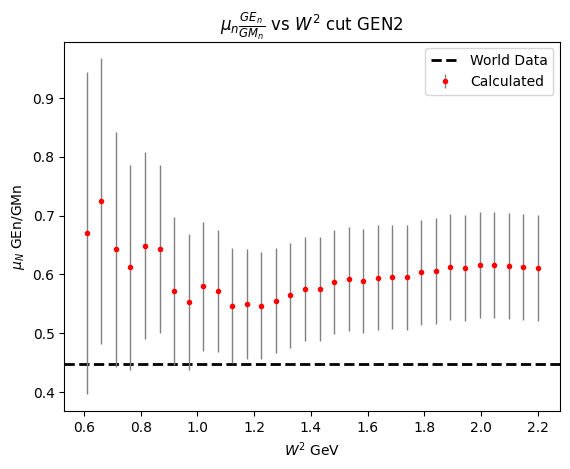

In [17]:
config="2"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(w2_2,2*abs(R_2w2),2*abs(RE_2w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $W^2$ cut GEN'+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_w2.npy', {
    'R': 2*abs(R_2w2),
    'RE': 2*abs(RE_2w2),
    'cut': w2_2,
},allow_pickle=True)


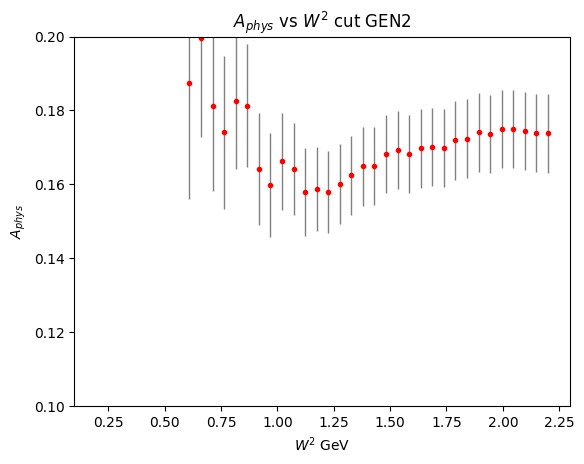

In [18]:

config="2"
plt.errorbar(w2_2,A_result_2w2,E_result_2w2,fmt='.',ecolor='grey',color='red',lw=1)
#plt.plot(w2_2,Y_2)
#plt.yscale('log')
plt.ylim(.1,.2)
plt.title("$A_{phys}$ vs $W^2$ cut GEN"+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_w2.npy', {
    'A': A_result_2w2,
    'AE': E_result_2w2,
    'cut': w2_2,
},allow_pickle=True)

# dY

In [19]:
%%time
n_jobs = -1  # Use all available CPU cores
Results2dy = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdy,val) for (val) in valuedy)

CPU times: user 278 ms, sys: 268 ms, total: 546 ms
Wall time: 8min 49s


In [20]:
A_result_2dy=np.empty(0)
E_result_2dy=np.empty(0)
fbg_result_2dy=np.empty(0)
cut_result_2dy=np.empty(0)
dy_2=np.empty(0)
Y_2dy=np.empty(0)
R_2dy=np.empty(0)
RE_2dy=np.empty(0)

for i in range(0,len(Results2dy)):
    A_result_2dy=np.append(A_result_2dy,Results2dy[i][0])
    E_result_2dy=np.append(E_result_2dy,Results2dy[i][1])  
    fbg_result_2dy=np.append(fbg_result_2dy,Results2dy[i][2])
    cut_result_2dy=np.append(cut_result_2dy,Results2dy[i][3])
    dy_2=np.append(dy_2,Results2dy[i][4][1])
    Y_2dy=np.append(Y_2dy,Results2dy[i][5])
    R_2dy=np.append(R_2dy,Results2dy[i][6])
    RE_2dy=np.append(RE_2dy,Results2dy[i][7])

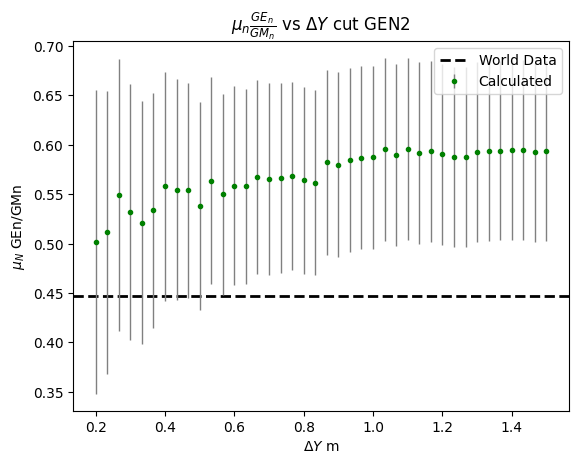

In [48]:
config="2"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dy_2,2*abs(R_2dy),2*abs(RE_2dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta Y$ cut GEN'+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dy.npy', {
    'R': 2*abs(R_2dy),
    'RE': 2*abs(RE_2dy),
    'cut': w2_2,
},allow_pickle=True)


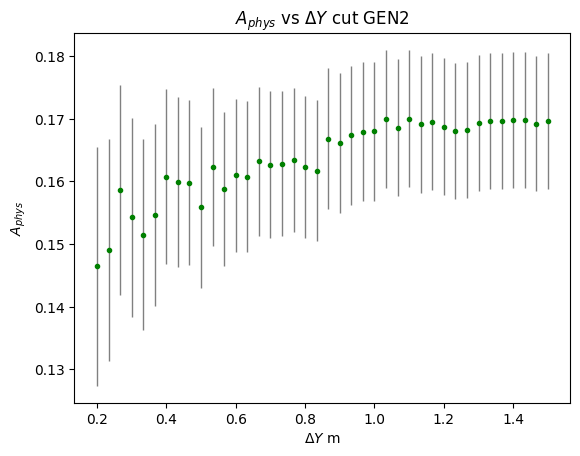

In [21]:
config="2"
plt.errorbar(dy_2,A_result_2dy,E_result_2dy,fmt='.',ecolor='grey',color='green',lw=1)
plt.title("$A_{phys}$ vs $\Delta Y$ cut GEN"+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dy.npy', {
    'A': A_result_2dy,
    'AE': E_result_2dy,
    'cut': dy_2,
},allow_pickle=True)

# dx

In [22]:
%%time
n_jobs = -1  # Use all available CPU cores
Results2dx = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdx,val) for (val) in valuedx)

CPU times: user 260 ms, sys: 255 ms, total: 515 ms
Wall time: 8min 43s


In [23]:
A_result_2dx=np.empty(0)
E_result_2dx=np.empty(0)
fbg_result_2dx=np.empty(0)
cut_result_2dx=np.empty(0)
dx_2=np.empty(0)
Y_2dx=np.empty(0)
R_2dx=np.empty(0)
RE_2dx=np.empty(0)

for i in range(0,len(Results2dx)):
    A_result_2dx=np.append(A_result_2dx,Results2dx[i][0])
    E_result_2dx=np.append(E_result_2dx,Results2dx[i][1])  
    fbg_result_2dx=np.append(fbg_result_2dx,Results2dx[i][2])
    cut_result_2dx=np.append(cut_result_2dx,Results2dx[i][3])
    dx_2=np.append(dx_2,Results2dx[i][4][1])
    Y_2dx=np.append(Y_2dx,Results2dx[i][5])
    R_2dx=np.append(R_2dx,Results2dx[i][6])
    RE_2dx=np.append(RE_2dx,Results2dx[i][7])

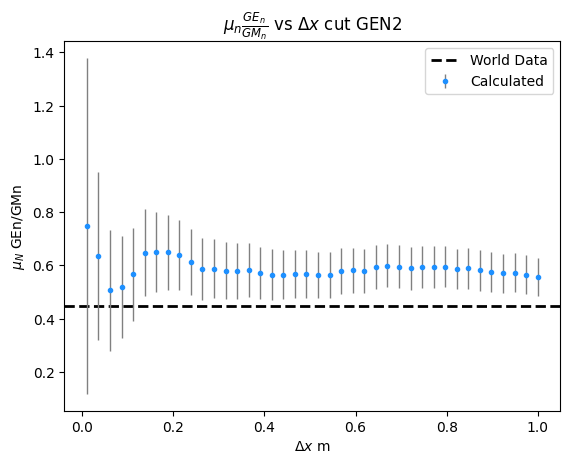

In [50]:
config="2"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dx_2,2*abs(R_2dx),2*abs(RE_2dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta x$ cut GEN'+config)
plt.xlabel("$\Delta x$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dx.npy', {
    'R': 2*abs(R_2dx),
    'RE': 2*abs(RE_2dx),
    'cut': dx_2,
},allow_pickle=True)

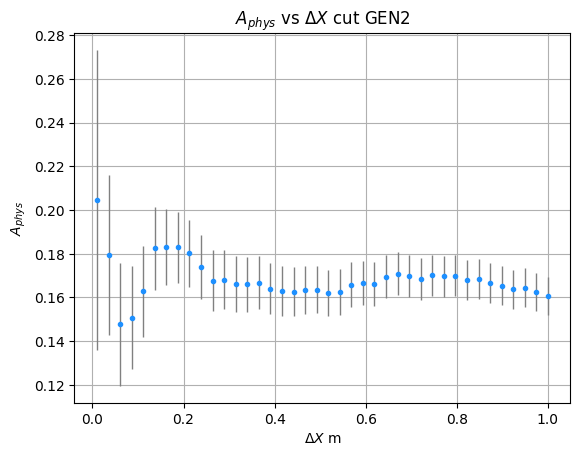

In [24]:
config="2"
plt.errorbar(dx_2,A_result_2dx,E_result_2dx,fmt='.',ecolor='grey',color='dodgerblue',lw=1)
plt.title("$A_{phys}$ vs $\Delta X$ cut GEN"+config)
plt.xlabel("$\Delta X$ m")
plt.grid()
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dx.npy', {
    'A': A_result_2dx,
    'AE': E_result_2dx,
    'cut': dx_2,
},allow_pickle=True)

# GEN3___________________________________________________________

In [25]:
config="3"

# W2

In [26]:
%%time
pas="1"
n_jobs = -1  # Use all available CPU cores
Results3 = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutw2,val) for (val) in valuew2)



CPU times: user 298 ms, sys: 258 ms, total: 556 ms
Wall time: 9min 7s


In [28]:
A_result_3=np.empty(0)
E_result_3=np.empty(0)
fbg_result_3=np.empty(0)
cut_result_3=np.empty(0)
w2_3=np.empty(0)
Y_3=np.empty(0)
R_3w2=np.empty(0)
RE_3w2=np.empty(0)

for i in range(0,len(Results3)):
    A_result_3=np.append(A_result_3,Results3[i][0])
    E_result_3=np.append(E_result_3,Results3[i][1])  
    fbg_result_3=np.append(fbg_result_3,Results3[i][2])
    cut_result_3=np.append(cut_result_3,Results3[i][3])
    w2_3=np.append(w2_3,Results3[i][4][1])
    Y_3=np.append(Y_3,Results3[i][5])
    R_3w2=np.append(R_3w2,Results3[i][6])
    RE_3w2=np.append(RE_3w2,Results3[i][7])

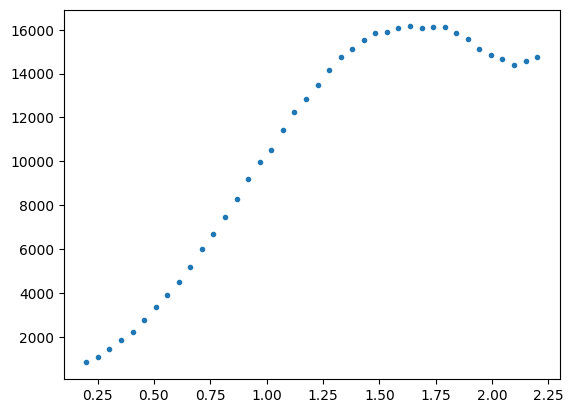

In [60]:
plt.plot(w2_3,Y_3,'.')

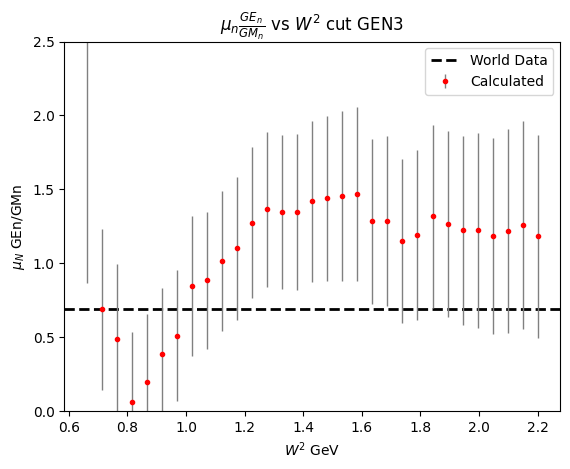

In [54]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(w2_3,2*abs(R_3w2),2*abs(RE_3w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $W^2$ cut GEN'+config)
plt.xlabel("$W^2$ GeV")
plt.ylim(0,2.5)
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_w2.npy', {
    'R': 2*abs(R_3w2),
    'RE': 2*abs(RE_3w2),
    'cut': w2_3,
},allow_pickle=True)

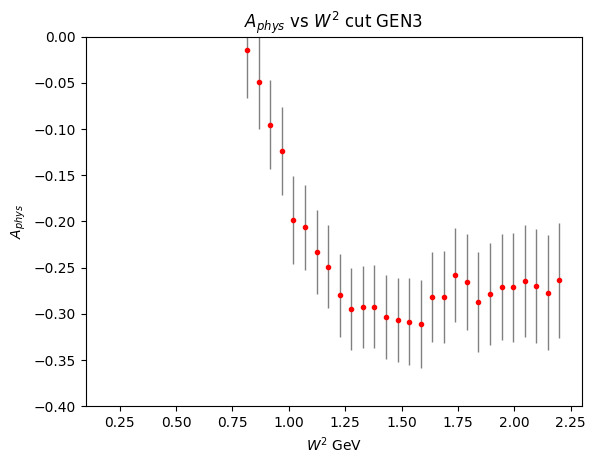

In [30]:
config="3"
plt.errorbar(w2_3,A_result_3,E_result_3,fmt='.',ecolor='grey',color='red',lw=1)
plt.ylim(-.4,0)
plt.title("$A_{phys}$ vs $W^2$ cut GEN"+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_w2.npy', {
    'A': A_result_3,
    'AE': E_result_3,
    'cut': w2_3,
},allow_pickle=True)

# dy

In [29]:
%%time
n_jobs = -1  # Use all available CPU cores
Results3dy = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdy,val) for (val) in valuedy)

CPU times: user 349 ms, sys: 289 ms, total: 638 ms
Wall time: 8min 57s


In [31]:
A_result_3dy=np.empty(0)
E_result_3dy=np.empty(0)
fbg_result_3dy=np.empty(0)
cut_result_3dy=np.empty(0)
dy_3=np.empty(0)
Y_3dy=np.empty(0)
R_3dy=np.empty(0)
RE_3dy=np.empty(0)

for i in range(0,len(Results3dy)):
    A_result_3dy=np.append(A_result_3dy,Results3dy[i][0])
    E_result_3dy=np.append(E_result_3dy,Results3dy[i][1])  
    fbg_result_3dy=np.append(fbg_result_3dy,Results3dy[i][2])
    cut_result_3dy=np.append(cut_result_3dy,Results3dy[i][3])
    dy_3=np.append(dy_3,Results3dy[i][4][1])
    Y_3dy=np.append(Y_3dy,Results3dy[i][5])
    R_3dy=np.append(R_3dy,Results3dy[i][6])
    RE_3dy=np.append(RE_3dy,Results3dy[i][7])

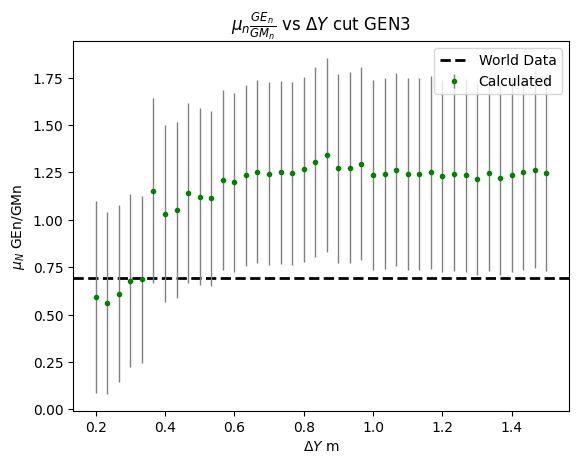

In [61]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dy_3,2*abs(R_3dy),2*abs(RE_3dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta Y$ cut GEN'+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dy.npy', {
    'R': 2*abs(R_3dy),
    'RE': 2*abs(RE_3dy),
    'cut': dy_3,
},allow_pickle=True)


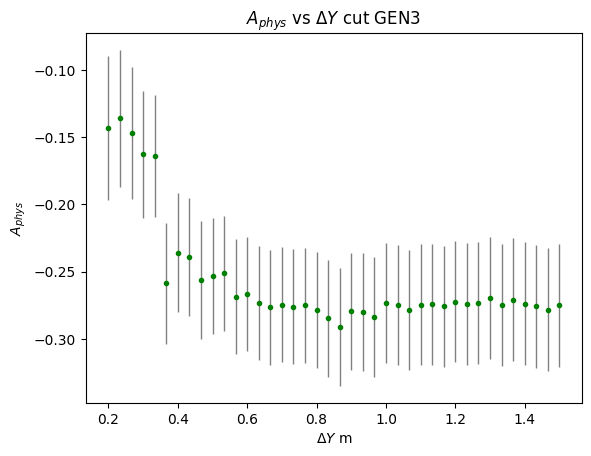

In [32]:
config="3"
plt.errorbar(dy_3,A_result_3dy,E_result_3dy,fmt='.',ecolor='grey',color='green',lw=1)
plt.title("$A_{phys}$ vs $\Delta Y$ cut GEN"+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dy.npy', {
    'A': A_result_3dy,
    'AE': E_result_3dy,
    'cut': dy_3,
},allow_pickle=True)

# dx

In [33]:
%%time
n_jobs = -1  # Use all available CPU cores
Results3dx = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdx,val) for (val) in valuedx)

CPU times: user 307 ms, sys: 238 ms, total: 544 ms
Wall time: 8min 54s


In [34]:
A_result_3dx=np.empty(0)
E_result_3dx=np.empty(0)
fbg_result_3dx=np.empty(0)
cut_result_3dx=np.empty(0)
dx_3=np.empty(0)
Y_3dx=np.empty(0)
R_3dx=np.empty(0)
RE_3dx=np.empty(0)

for i in range(0,len(Results3dx)):
    A_result_3dx=np.append(A_result_3dx,Results3dx[i][0])
    E_result_3dx=np.append(E_result_3dx,Results3dx[i][1])  
    fbg_result_3dx=np.append(fbg_result_3dx,Results3dx[i][2])
    cut_result_3dx=np.append(cut_result_3dx,Results3dx[i][3])
    dx_3=np.append(dx_3,Results3dx[i][4][1])
    Y_3dx=np.append(Y_3dx,Results3dx[i][5])
    R_3dx=np.append(R_3dx,Results3dx[i][6])
    RE_3dx=np.append(RE_3dx,Results3dx[i][7])

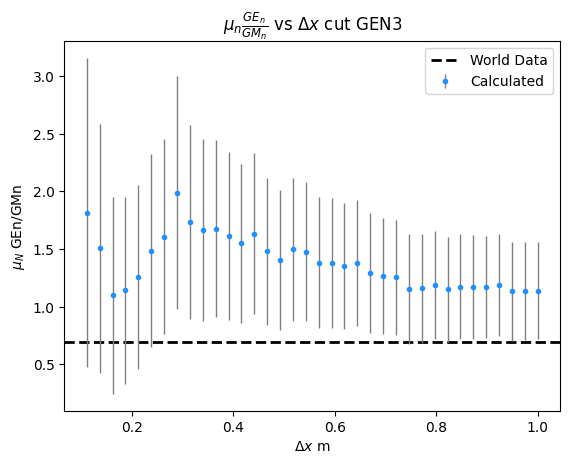

In [62]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dx_3,2*abs(R_3dx),2*abs(RE_3dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta x$ cut GEN'+config)
plt.xlabel("$\Delta x$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dx.npy', {
    'R': 2*abs(R_3dx),
    'RE': 2*abs(RE_3dx),
    'cut': dx_3,
},allow_pickle=True)

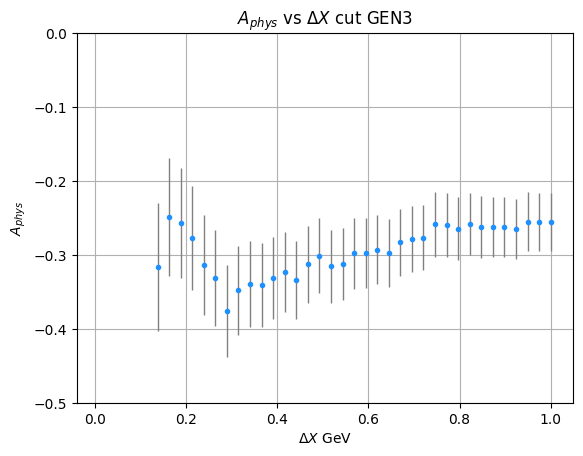

In [35]:
config="3"
plt.errorbar(dx_3,A_result_3dx,E_result_3dx,fmt='.',ecolor='grey',color='dodgerblue',lw=1)
plt.title("$A_{phys}$ vs $\Delta X$ cut GEN"+config)
plt.xlabel("$\Delta X$ GeV")
plt.ylabel("$A_{phys}$")
plt.ylim(-.5,0)
plt.grid()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dx.npy', {
    'A': A_result_3dx,
    'AE': E_result_3dx,
    'cut': dx_3,
},allow_pickle=True)

# GEN4

# W2

In [36]:
config="4"

In [37]:
%%time
pas="1"
n_jobs = -1  # Use all available CPU cores
Results4= Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutw2,val) for (val) in valuew2)

CPU times: user 146 ms, sys: 60.3 ms, total: 206 ms
Wall time: 2min 58s


In [38]:
A_result_4=np.empty(0)
E_result_4=np.empty(0)
fbg_result_4=np.empty(0)
cut_result_4=np.empty(0)
w2_4=np.empty(0)
Y_4=np.empty(0)
R_4w2=np.empty(0)
RE_4w2=np.empty(0)

for i in range(0,len(Results4)):
    A_result_4=np.append(A_result_4,Results4[i][0])
    E_result_4=np.append(E_result_4,Results4[i][1])  
    fbg_result_4=np.append(fbg_result_4,Results4[i][2])
    cut_result_4=np.append(cut_result_4,Results4[i][3])
    w2_4=np.append(w2_4,Results4[i][4][1])
    Y_4=np.append(Y_4,Results4[i][5])
    R_4w2=np.append(R_4w2,Results4[i][6])
    RE_4w2=np.append(RE_4w2,Results4[i][7])

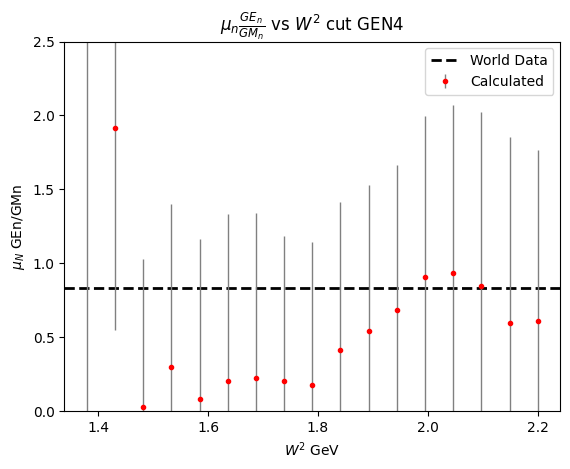

In [65]:
config="4"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(w2_4,2*abs(R_4w2),2*abs(RE_4w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $W^2$ cut GEN'+config)
plt.xlabel("$W^2$ GeV")
plt.ylim(0,2.5)
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_w2.npy', {
    'R': 2*abs(R_4w2),
    'RE': 2*abs(RE_4w2),
    'cut': w2_4,
},allow_pickle=True)

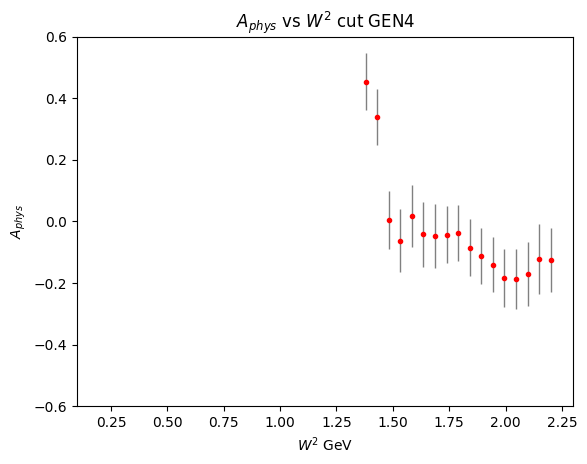

In [39]:
config="4"
plt.errorbar(w2_4,A_result_4,E_result_4,fmt='.',ecolor='grey',color='red',lw=1)
plt.title("$A_{phys}$ vs $W^2$ cut GEN"+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel("$A_{phys}$")
plt.ylim(-.6,.6)
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_w2.png")

# dy

In [40]:
%%time
n_jobs = -1  # Use all available CPU cores
Results4dy = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdy,val) for (val) in valuedy)

CPU times: user 114 ms, sys: 98.6 ms, total: 212 ms
Wall time: 2min 59s


In [41]:
A_result_4dy=np.empty(0)
E_result_4dy=np.empty(0)
fbg_result_4dy=np.empty(0)
cut_result_4dy=np.empty(0)
dy_4=np.empty(0)
Y_4dy=np.empty(0)
R_4dy=np.empty(0)
RE_4dy=np.empty(0)

for i in range(0,len(Results4dy)):
    A_result_4dy=np.append(A_result_4dy,Results4dy[i][0])
    E_result_4dy=np.append(E_result_4dy,Results4dy[i][1])  
    fbg_result_4dy=np.append(fbg_result_4dy,Results4dy[i][2])
    cut_result_4dy=np.append(cut_result_4dy,Results4dy[i][3])
    dy_4=np.append(dy_4,Results4dy[i][4][1])
    Y_4dy=np.append(Y_4dy,Results4dy[i][5])
    R_4dy=np.append(R_4dy,Results4dy[i][6])
    RE_4dy=np.append(RE_4dy,Results4dy[i][7])

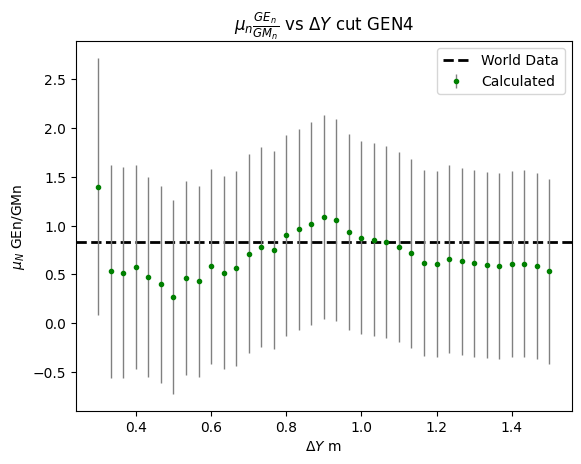

In [64]:
config="4"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dy_4,2*abs(R_4dy),2*abs(RE_4dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta Y$ cut GEN'+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dy.npy', {
    'R': 2*abs(R_4dy),
    'RE': 2*abs(RE_4dy),
    'cut': dy_4,
},allow_pickle=True)

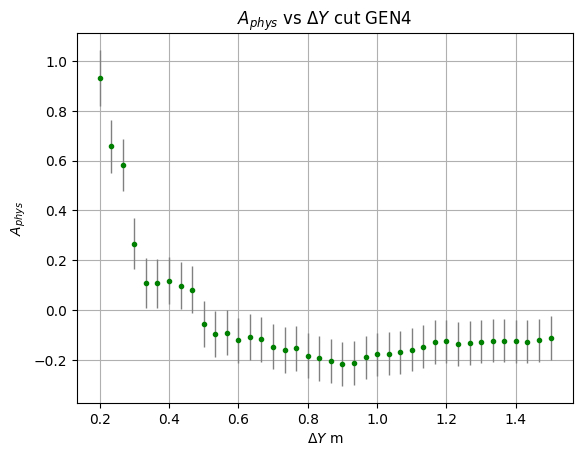

In [46]:
config="4"
plt.errorbar(dy_4,A_result_4dy,E_result_4dy,fmt='.',ecolor='grey',color='green',lw=1)
plt.title("$A_{phys}$ vs $\Delta Y$ cut GEN"+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel("$A_{phys}$")
#plt.ylim(0,.6)
plt.grid()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dy.png")

# dx

In [43]:
%%time
n_jobs = -1  # Use all available CPU cores
Results4dx = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdx,val) for (val) in valuedx)

CPU times: user 111 ms, sys: 96.5 ms, total: 208 ms
Wall time: 2min 57s


In [44]:
A_result_4dx=np.empty(0)
E_result_4dx=np.empty(0)
fbg_result_4dx=np.empty(0)
cut_result_4dx=np.empty(0)
dx_4=np.empty(0)
Y_4dx=np.empty(0)
R_4dx=np.empty(0)
RE_4dx=np.empty(0)

for i in range(0,len(Results4dx)):
    A_result_4dx=np.append(A_result_4dx,Results4dx[i][0])
    E_result_4dx=np.append(E_result_4dx,Results4dx[i][1])  
    fbg_result_4dx=np.append(fbg_result_4dx,Results4dx[i][2])
    cut_result_4dx=np.append(cut_result_4dx,Results4dx[i][3])
    dx_4=np.append(dx_4,Results4dx[i][4][1])
    Y_4dx=np.append(Y_4dx,Results4dx[i][5])
    R_4dx=np.append(R_4dx,Results4dx[i][6])
    RE_4dx=np.append(RE_4dx,Results4dx[i][7])

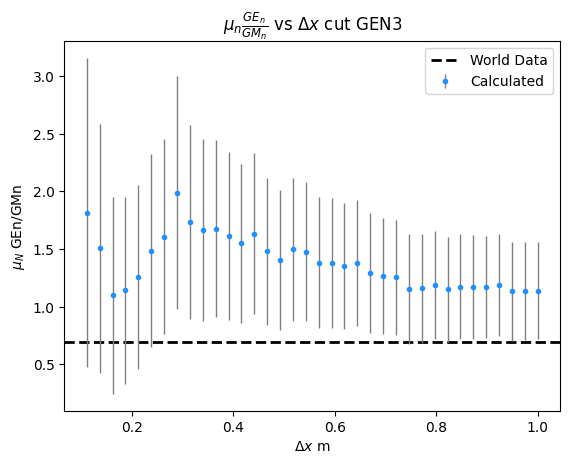

In [63]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dx_3,2*abs(R_3dx),2*abs(RE_3dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta x$ cut GEN'+config)
plt.xlabel("$\Delta x$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dx.npy', {
    'R': 2*abs(R_3dx),
    'RE': 2*abs(RE_3dx),
    'cut': dx_3,
},allow_pickle=True)

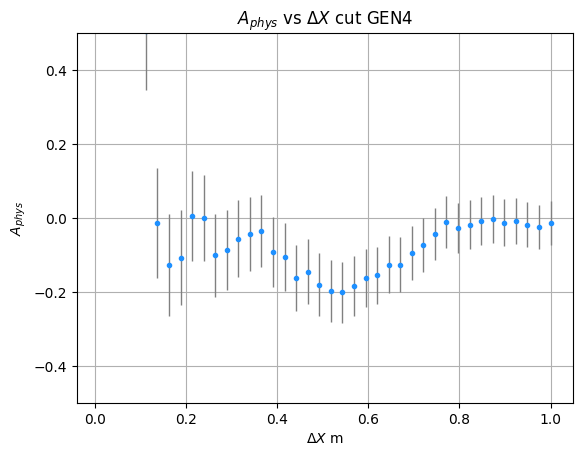

In [45]:
config="4"
plt.errorbar(dx_4,A_result_4dx,E_result_4dx,fmt='.',ecolor='grey',color='dodgerblue',lw=1)
plt.title("$A_{phys}$ vs $\Delta X$ cut GEN"+config)
plt.xlabel("$\Delta X$ m")
plt.ylabel("$A_{phys}$")
plt.ylim(-.5,.5)
plt.grid()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dx.png")

# Nice Plotting

In [75]:
from DXDYW2COIN import *

# GEN2 Plots

In [76]:
config="2"

dxHist2,dyHist2,w2Hist2=Function_MAKEHIST(config)

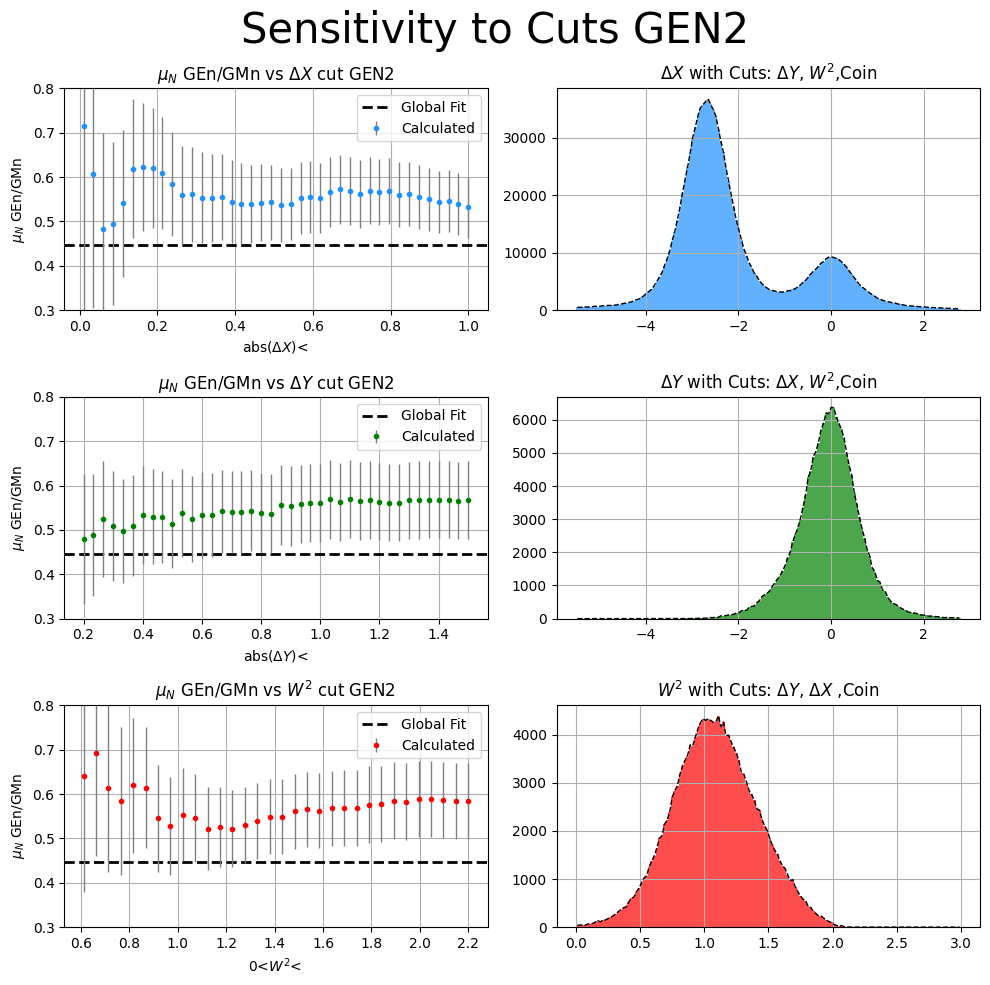

In [84]:
config="2"
lw=1
plt.figure(figsize=(10,10))
plt.suptitle('Sensitivity to Cuts GEN2', fontsize=30)

plt.subplot(3,2,1)
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.errorbar(dx_2,muN*abs(R_2dx),muN*abs(RE_2dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta X$ cut GEN"+config)
plt.xlabel("abs($\Delta X$)< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.3,.8)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,3)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')

plt.errorbar(dy_2,muN*abs(R_2dy),muN*abs(RE_2dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta Y$ cut GEN"+config)
plt.xlabel("abs($\Delta Y$)<")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.3,.8)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,5)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.grid()
plt.errorbar(w2_2,muN*abs(R_2w2),muN*abs(RE_2w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $W^2$ cut GEN"+config)
plt.xlabel("0<$W^2$< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.3,.8)
plt.legend(loc="upper right")

plt.subplot(3,2,2)
plt.title("$\Delta X$ with Cuts: $\Delta Y$, $W^2$,Coin")
bin_centers,bin_contents=dxHist2
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="$\Delta X$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,4)
plt.title("$\Delta Y$ with Cuts: $\Delta X$, $W^2$,Coin")
bin_centers,bin_contents=dyHist2
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="green",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,6)
plt.title("$W^2$ with Cuts: $\Delta Y$, $\Delta X$ ,Coin")
bin_centers,bin_contents=w2Hist2
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="red",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()

plt.tight_layout()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RAT_allcuts.png")


# GEN3 Plots

In [85]:
config="3"

dxHist3,dyHist3,w2Hist3=Function_MAKEHIST(config)

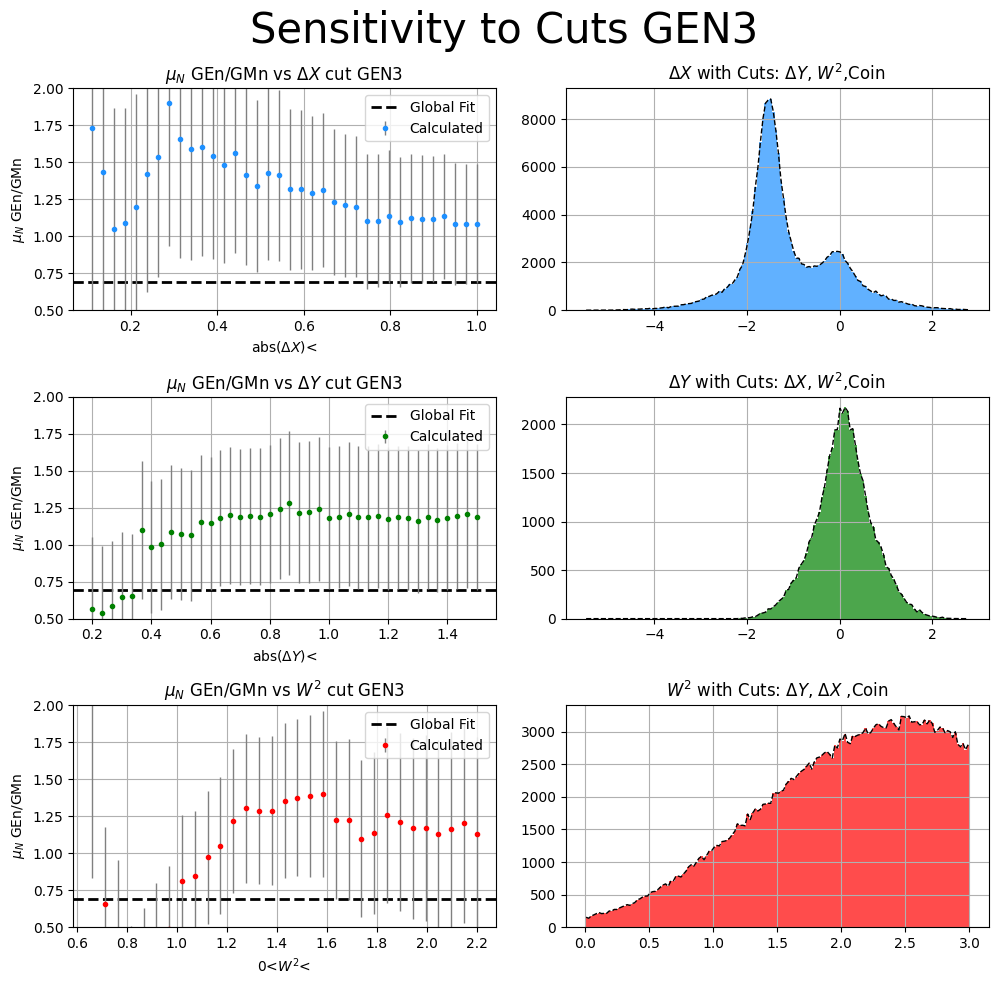

In [95]:
config="3"
lw=1
plt.figure(figsize=(10,10))
plt.suptitle('Sensitivity to Cuts GEN3', fontsize=30)

plt.subplot(3,2,1)
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.errorbar(dx_3,muN*abs(R_3dx),muN*abs(RE_3dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta X$ cut GEN"+config)
plt.xlabel("abs($\Delta X$)< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.5,2)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,3)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')

plt.errorbar(dy_3,muN*abs(R_3dy),muN*abs(RE_3dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta Y$ cut GEN"+config)
plt.xlabel("abs($\Delta Y$)<")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.5,2)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,5)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.grid()
plt.errorbar(w2_3,muN*abs(R_3w2),muN*abs(RE_3w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $W^2$ cut GEN"+config)
plt.xlabel("0<$W^2$< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.5,2)
plt.legend(loc="upper right")

plt.subplot(3,2,2)
plt.title("$\Delta X$ with Cuts: $\Delta Y$, $W^2$,Coin")
bin_centers,bin_contents=dxHist3
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="$\Delta X$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,4)
plt.title("$\Delta Y$ with Cuts: $\Delta X$, $W^2$,Coin")
bin_centers,bin_contents=dyHist3
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="green",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,6)
plt.title("$W^2$ with Cuts: $\Delta Y$, $\Delta X$ ,Coin")
bin_centers,bin_contents=w2Hist3
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="red",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()

plt.tight_layout()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RAT_allcuts.png")


# GEN4 Plots

In [87]:
config="4"

dxHist4,dyHist4,w2Hist4=Function_MAKEHIST(config)

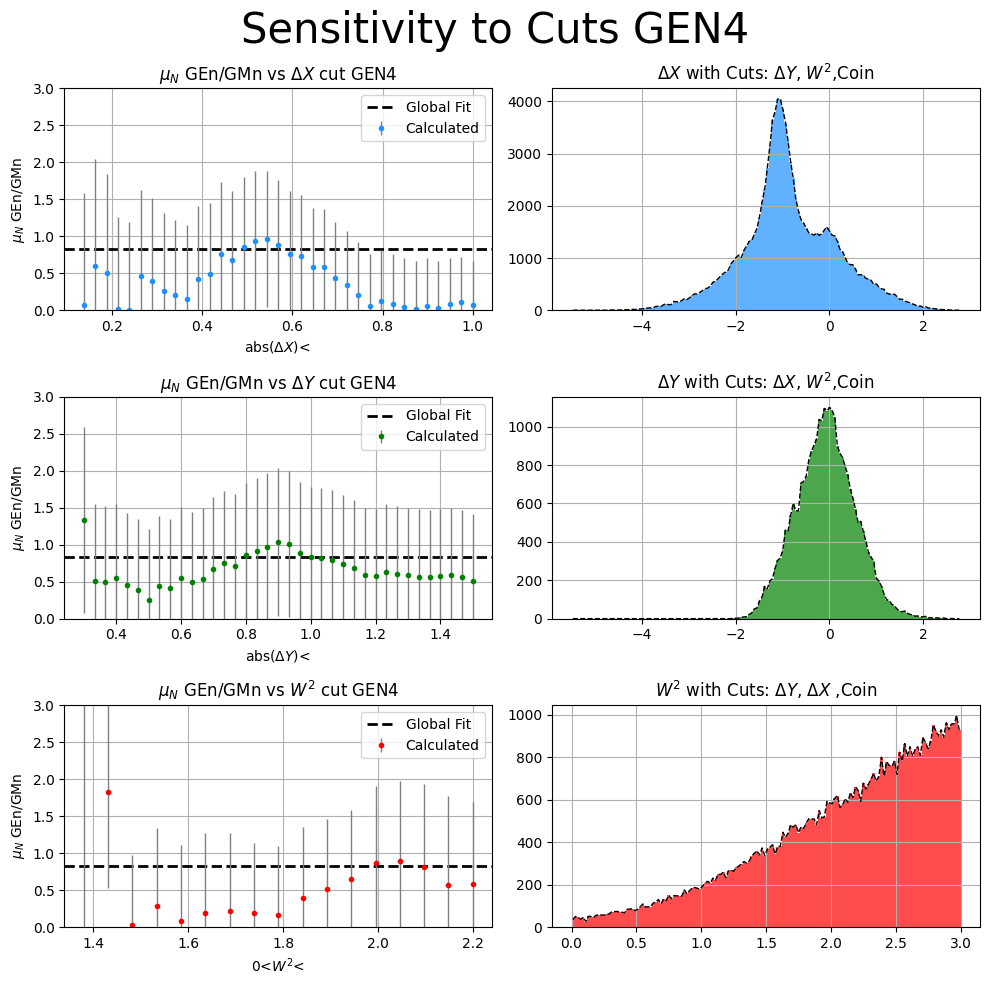

In [94]:
config="4"
lw=1
plt.figure(figsize=(10,10))
plt.suptitle('Sensitivity to Cuts GEN4', fontsize=30)

plt.subplot(3,2,1)
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.errorbar(dx_4,muN*abs(R_4dx),muN*abs(RE_4dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta X$ cut GEN"+config)
plt.xlabel("abs($\Delta X$)< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(0,3)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,3)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')

plt.errorbar(dy_4,muN*abs(R_4dy),muN*abs(RE_4dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta Y$ cut GEN"+config)
plt.xlabel("abs($\Delta Y$)<")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(0,3)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,5)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.grid()
plt.errorbar(w2_4,muN*abs(R_4w2),muN*abs(RE_4w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $W^2$ cut GEN"+config)
plt.xlabel("0<$W^2$< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(0,3)
plt.legend(loc="upper right")

plt.subplot(3,2,2)
plt.title("$\Delta X$ with Cuts: $\Delta Y$, $W^2$,Coin")
bin_centers,bin_contents=dxHist4
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="$\Delta X$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,4)
plt.title("$\Delta Y$ with Cuts: $\Delta X$, $W^2$,Coin")
bin_centers,bin_contents=dyHist4
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="green",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,6)
plt.title("$W^2$ with Cuts: $\Delta Y$, $\Delta X$ ,Coin")
bin_centers,bin_contents=w2Hist4
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="red",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()

plt.tight_layout()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RAT_allcuts.png")
